# Access Rogue from notebook

## -------------------- BASIC START ------------------

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = True,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 1 day, 0:38:14
GitHash      = 0x7396087201c6d0e2c27a74a429eb8ea72bd323fe
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 19 Jul 2023 01:22:51 PM PDT
Builder      = dnajjar
###################################################


# Open Interface: 


In [5]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
!python -m pyrogue gui --server='rdsrv314:9099'

Rogue/pyrogue version v5.16.0. https://github.com/slaclab/rogue
Connecting to rdsrv314:9099
ZmqClient::setTimeout: Setting timeout to 1000 msecs, waitRetry = 1
Connected to Root at rdsrv314:9099
Running GUI. Close window, hit cntrl-c or send SIGTERM to 1549823 to exit.
Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.sta

In [3]:
"""
REGISTER(s): SHORT-HAND
"""
# SETUP SHORT HAND FOR ROOT CALLS
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0x0
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/noteb

## Template test

In [55]:
#get locked lanes
for asicIndex in range(4) : 
    root.App.SspMonGrp[asicIndex].enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [71]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x0
ASIC1: 0x100001
ASIC2: 0xc90000
ASIC3: 0x0


In [73]:
#check current frames in receivers
for asicIndex in range(4):
    print("DataReceiver {} received {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

DataReceiver 0 received 27 frames
DataReceiver 1 received 0 frames
DataReceiver 2 received 0 frames
DataReceiver 3 received 0 frames


In [77]:
#trigger
print("Before Trigger: {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))
root.Trigger()
print("After Trigger:  {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))

Before Trigger: 715
After Trigger:  716


In [79]:
# Obtain descrambled data from ASIC0
frame = root.DataReceiver0.Data.get()
print(frame)

[[16905 16730 16234 ... 19818 18822 18570]
 [17243 17491 16373 ... 20062 19213 18813]
 [16998 17143 16015 ... 19945 19091 19152]
 ...
 [17090 18209 17871 ... 21658 18759 19891]
 [17319 18285 18051 ... 21533 19110 19778]
 [16979 18209 18421 ... 21502 18761 19786]]


In [80]:
#frame dimensions
np.shape(frame)

(192, 384)

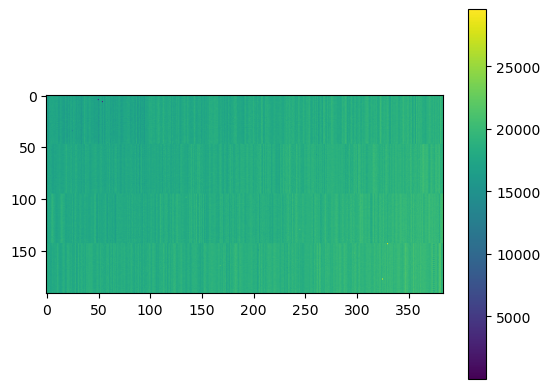

In [86]:
#plot image
plt.imshow(frame)
plt.colorbar()

In [89]:
#Manipulate ASIC register
for asicIndex in range(4) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    